
# Readmission Risk Midterm - ML Zoomcamp 2025 Cohort

The goal is to predict **30-day readmission** for patients based on their demographics, vitals, labs, and diagnosis. Datasource is synthetic clinical dataset from Kaggle. This dataset and project were chosen because I currently work in healthcare as an Industrial Engineer and this is something I am familiar with but never had the opportunity to apply prediction modeling to this particular critical health issue. The dataset is designed to closely mimic real-world patient health records while ensuring zero personally identifiable information (PII). A machine learning model can be used because this problem presents itself as a Binary Classification. As a reference, Sepsis is a very serious and life threatning infection that triggers overaggressive immune response that damages itssues and organs. It can happen anywhere in the body and spreads quickly. Thus it has to be treated quickly or it can you. If you survive you are likely to be at a higher risk for re-hospilization after discharge.

Datasource Link: https://www.kaggle.com/datasets/uom190346a/synthetic-clinical-tabular-dataset

In each section, we explain:
- **What the code is doing**
- **Why we are doing it** in the context of a ML Workflow

**Target:** `readmission_30d` (0/1) — binary classification problem.

**Metrics:**
- Primary: **ROC AUC** (how well the model ranks positives vs negatives)
- Secondary: **F1** and **accuracy** to get a sense of performance at a chosen threshold.


## 0) Library Import & File Directory Listing

In [ ]:
# Import needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from pathlib import Path
import joblib
import json

In [32]:
# Notebook location (typically .../project/notebooks)
NOTEBOOK_DIR = Path().resolve()

# Project root = parent directory
PROJECT_ROOT = NOTEBOOK_DIR.parent

print("🔍 Notebook directory:", NOTEBOOK_DIR)
print("🗂️ Project root directory:", PROJECT_ROOT)

# Expected artifacts directory
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

print("📦 Artifacts will be saved to:", ARTIFACTS_DIR)

# Create it if missing
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Also confirm dataset path
DATASET_PATH = PROJECT_ROOT / "data" / "synthetic_clinical_dataset.csv"
print("📄 Dataset expected at:", DATASET_PATH)
print("   Exists:", DATASET_PATH.exists())

🔍 Notebook directory: /Users/kashundavis/Desktop/ml-zoomcamp-2025/midterm/readmission_midterm_project/notebooks
🗂️ Project root directory: /Users/kashundavis/Desktop/ml-zoomcamp-2025/midterm/readmission_midterm_project
📦 Artifacts will be saved to: /Users/kashundavis/Desktop/ml-zoomcamp-2025/midterm/readmission_midterm_project/artifacts
📄 Dataset expected at: /Users/kashundavis/Desktop/ml-zoomcamp-2025/midterm/readmission_midterm_project/data/synthetic_clinical_dataset.csv
   Exists: True



## 1) Data & Leakage Prevention

**What this section does:**
- Loads the raw CSV into a pandas DataFrame.
- Standardizes column names to lowercase (to avoid bugs from naming differences).
- Gives a quick preview of the data and basic info (types, missing values).
- Checks the class balance of the target.

**Why this matters:**
Before any modeling, we need to understand **what columns exist** and **verify that the target is present**.
We also want to prevent **data leakage**, which means accidentally using future/outcome information when
training the model.

Here, we explicitly mention which features we will use:
- `age, sex, bmi, systolic_bp, diastolic_bp, glucose, cholesterol, creatinine, diabetes, hypertension, diagnosis`

We also note that we **must not use `mortality`** (or other outcome variables) when predicting `readmission_30d`,
because that would give the model “cheating” information it wouldn’t have in real time.


In [33]:
CSV_PATH = ("../data/synthetic_clinical_dataset.csv")

df = pd.read_csv(CSV_PATH)

# Standardize column names to lowercase
df.columns = [c.strip().lower() for c in df.columns]

df.head(5)


,patient_id,age,sex,bmi,systolic_bp,diastolic_bp,glucose,cholesterol,creatinine,diabetes,hypertension,diagnosis,readmission_30d,mortality
0,1001,63,Male,24.1,131.0,81.0,136.2,210.3,1.04,0,0,Sepsis,0,0
1,1002,52,Male,20.8,118.0,91.0,136.5,207.9,1.49,0,1,Normal,0,0
2,1003,66,Male,30.0,144.0,73.0,100.0,179.5,1.15,0,0,Normal,0,0
3,1004,82,Male,16.8,112.0,76.0,117.3,228.3,0.59,0,0,Heart Failure,0,0
4,1005,50,Female,25.4,102.0,65.0,128.0,150.7,1.38,0,0,Normal,0,0


In [34]:
# Basic info
df.info()

print("\nMissing values per column:")
print(df.isna().sum())

print("\nPreview of target (readmission_30d) counts and proportions:")
print(df["readmission_30d"].value_counts())
print(df["readmission_30d"].value_counts(normalize=True))
print(df["sex"].value_counts(normalize=True))
print(df["diabetes"].value_counts(normalize=True))
print("\n")

# Numeric ranges for integers and descriptive stats for categories/objects
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       10000 non-null  int64  
 1   age              10000 non-null  int64  
 2   sex              10000 non-null  object 
 3   bmi              10000 non-null  float64
 4   systolic_bp      10000 non-null  float64
 5   diastolic_bp     10000 non-null  float64
 6   glucose          10000 non-null  float64
 7   cholesterol      10000 non-null  float64
 8   creatinine       10000 non-null  float64
 9   diabetes         10000 non-null  int64  
 10  hypertension     10000 non-null  int64  
 11  diagnosis        10000 non-null  object 
 12  readmission_30d  10000 non-null  int64  
 13  mortality        10000 non-null  int64  
dtypes: float64(6), int64(6), object(2)
memory usage: 1.1+ MB

Missing values per column:
patient_id         0
age                0
sex                0
bmi

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patient_id,10000.0,NaN,NaN,NaN,6000.5,2886.89568,1001.0,3500.75,6000.5,8500.25,11000.0
age,10000.0,NaN,NaN,NaN,54.2997,17.640232,0.0,42.0,54.0,67.0,90.0
sex,10000,3,Female,5111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,10000.0,NaN,NaN,NaN,27.02217,5.832599,15.0,22.9,27.0,31.0,50.0
systolic_bp,10000.0,NaN,NaN,NaN,124.8147,17.648686,90.0,112.0,125.0,137.0,180.0
diastolic_bp,10000.0,NaN,NaN,NaN,80.3392,11.388859,60.0,72.0,80.0,88.0,110.0
glucose,10000.0,NaN,NaN,NaN,106.00984,23.375168,70.0,88.1,105.3,122.1,198.6
cholesterol,10000.0,NaN,NaN,NaN,190.89048,34.329647,120.0,166.775,190.85,214.4,300.0
creatinine,10000.0,NaN,NaN,NaN,1.003569,0.287716,0.5,0.79,1.0,1.2,2.13
diabetes,10000.0,NaN,NaN,NaN,0.1192,0.32404,0.0,0.0,0.0,0.0,1.0


In [35]:
# Optional: Removing rows with 'sex' listed as 'Other' since they account for ~1% of the data and appeared to have a stronger bias in the class balanced model at the end even with fairness. This can also be added back into the by commenting the line and re-running the notebook. This will warrant further investigation for the future.

df = df[df['sex'] != 'Other']

In [36]:
df.describe()

,patient_id,age,bmi,systolic_bp,diastolic_bp,glucose,cholesterol,creatinine,diabetes,hypertension,readmission_30d,mortality
count,9884.000000,9884.000000,9884.000000,9884.000000,9884.000000,9884.000000,9884.000000,9884.000000,9884.000000,9884.000000,9884.000000,9884.000000
mean,5998.721166,54.310907,27.010735,124.817179,80.339033,106.050880,190.879654,1.003834,0.119081,0.304836,0.139518,0.027317
std,2888.144053,17.657287,5.823890,17.670562,11.381693,23.382655,34.379403,0.287484,0.323901,0.460361,0.346504,0.163013
min,1001.000000,0.000000,15.000000,90.000000,60.000000,70.000000,120.000000,0.500000,0.000000,0.000000,0.000000,0.000000
25%,3497.750000,42.000000,22.800000,112.000000,72.000000,88.200000,166.700000,0.790000,0.000000,0.000000,0.000000,0.000000
50%,5994.500000,54.000000,27.000000,125.000000,80.000000,105.300000,190.800000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,8503.250000,67.000000,31.000000,137.000000,88.000000,122.200000,214.400000,1.200000,0.000000,1.000000,0.000000,0.000000
max,11000.000000,90.000000,50.000000,180.000000,110.000000,198.600000,300.000000,2.130000,1.000000,1.000000,1.000000,1.000000



## 2) Prep features

**What this section does:**
- Selects a clean list of input columns (`feat_cols`) and the target column (`readmission_30d`).
- Fills missing values in numeric columns with the **median** of that column.
- Converts categorical columns to strings, so they can be handled by `DictVectorizer`.
- Splits the data into feature matrix `X` and label vector `y`.
- Re-checks the class balance of the target.

**Why we do this:**
Machine learning models in scikit-learn expect **clean numeric arrays**.
Steps like:
- Handling missing values (imputation),
- Making sure categoricals are strings,
- Separating features from labels,

are all necessary to avoid runtime errors and to make the pipeline reproducible and consistent.


In [37]:

feat_cols = [
    "age", "sex", "bmi", "systolic_bp", "diastolic_bp",
    "glucose", "cholesterol", "creatinine",
    "diabetes", "hypertension", "diagnosis"
]
target_col = "readmission_30d"

# Simple imputes for numeric columns
for c in ["age", "bmi", "systolic_bp", "diastolic_bp", "glucose", "cholesterol", "creatinine"]:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# Ensure categorical columns are strings
for c in ["sex", "diabetes", "hypertension", "diagnosis"]:
    if c in df.columns:
        df[c] = df[c].astype(str)

X = df[feat_cols].copy()
y = df[target_col].astype(int)

print("Class balance (counts):")
print(y.value_counts())
print("\nClass balance (proportions):")
print(y.value_counts(normalize=True))


Class balance (counts):
readmission_30d
0    8505
1    1379
Name: count, dtype: int64

Class balance (proportions):
readmission_30d
0    0.860482
1    0.139518
Name: proportion, dtype: float64


In [38]:
X.head()

,age,sex,bmi,systolic_bp,diastolic_bp,glucose,cholesterol,creatinine,diabetes,hypertension,diagnosis
0,63,Male,24.1,131.0,81.0,136.2,210.3,1.04,0,0,Sepsis
1,52,Male,20.8,118.0,91.0,136.5,207.9,1.49,0,1,Normal
2,66,Male,30.0,144.0,73.0,100.0,179.5,1.15,0,0,Normal
3,82,Male,16.8,112.0,76.0,117.3,228.3,0.59,0,0,Heart Failure
4,50,Female,25.4,102.0,65.0,128.0,150.7,1.38,0,0,Normal


In [39]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: readmission_30d, dtype: int64


## 3) Models (Dummy → Logistic → RandomForest)

**What this section does:**
- Splits the data into **train** and **test** sets (with stratification, so class balance is preserved).
- Uses `DictVectorizer` to convert each row (Python dict) into a numeric feature vector.
- Trains three baseline models:
  - `DummyClassifier` (baseline that always predicts the most frequent class),
  - `LogisticRegression` (simple linear model),
  - `RandomForestClassifier` (non-linear tree ensemble).
- Evaluates each model on the test set using:
  - ROC AUC,
  - F1 score,
  - Accuracy,
  - Confusion matrix.
- Picks the **best base model** by ROC AUC.

**Why we do this:**
- A **dummy model** gives us a **floor**: if a real model isn’t better than the dummy, something is wrong.
- Logistic Regression is a good **interpretable baseline**.
- Random Forest captures **non-linear relationships** and interactions between features.
- Using ROC AUC as the main criterion helps us compare models on how well they **rank** positive vs. negative cases,
  even if the class distribution is imbalanced.


In [40]:
RANDOM_STATE = 42

# Train/test split with stratification to preserve target proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# DictVectorizer: converts rows (dicts) into numeric feature vectors
dv = DictVectorizer(sparse=True)
X_train_d = dv.fit_transform(X_train.to_dict(orient="records"))
X_test_d = dv.transform(X_test.to_dict(orient="records"))

In [41]:
X_train.describe()

,age,bmi,systolic_bp,diastolic_bp,glucose,cholesterol,creatinine
count,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000
mean,54.427975,27.022385,124.606425,80.396990,106.007474,190.729303,1.004573
std,17.599587,5.808411,17.655884,11.417778,23.502896,34.504929,0.285778
min,0.000000,15.000000,90.000000,60.000000,70.000000,120.000000,0.500000
25%,43.000000,22.900000,112.000000,72.000000,87.800000,166.400000,0.800000
50%,55.000000,27.000000,125.000000,80.000000,105.400000,191.000000,1.000000
75%,67.000000,31.000000,137.000000,88.000000,122.300000,214.250000,1.200000
max,90.000000,48.700000,180.000000,110.000000,198.600000,300.000000,2.130000


In [42]:
y_train.describe()

count    7907.000000
mean        0.139497
std         0.346486
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: readmission_30d, dtype: float64

In [43]:
y_test.describe()

count    1977.000000
mean        0.139605
std         0.346665
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: readmission_30d, dtype: float64

In [44]:
# Baseline models
models = {
    "dummy": DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE),
    "logreg": LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
}

metrics = {}
best_name, best_auc, best_model = None, -1, None

for name, m in models.items():
    m.fit(X_train_d, y_train)
    y_prob = m.predict_proba(X_test_d)[:, 1] if hasattr(m, "predict_proba") else m.predict(X_test_d).astype(float)
    y_pred = (y_prob >= 0.5).astype(int)
    met = {
        "roc_auc": roc_auc_score(y_test, y_prob),
        "f1": f1_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }
    metrics[name] = met
    if met["roc_auc"] > best_auc:
        best_name, best_auc, best_model = name, met["roc_auc"], m

metrics


{'dummy': {'roc_auc': 0.5,
  'f1': 0.0,
  'accuracy': 0.8603945371775418,
  'conf_matrix': array([[1701,    0],
         [ 276,    0]])},
 'logreg': {'roc_auc': 0.636170965075957,
  'f1': 0.0,
  'accuracy': 0.8603945371775418,
  'conf_matrix': array([[1701,    0],
         [ 276,    0]])},
 'rf': {'roc_auc': 0.6190508140991234,
  'f1': 0.014184397163120567,
  'accuracy': 0.8593829033889732,
  'conf_matrix': array([[1697,    4],
         [ 274,    2]])}}

In [45]:
print(best_name)

logreg



### 3.1 Simple hyperparameter tuning (Logistic & Random Forest)

Here we lightly tune Logistic Regression and Random Forest using `RandomizedSearchCV` to explore
a small space of hyperparameters and see if we can improve on the baseline models.


In [46]:

# Tuning on Logistic Regression & Random Forest
tuned = {}

search_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE),
    param_distributions={"C": np.logspace(-3, 3, 20)},
    n_iter=15, scoring="roc_auc", cv=3, random_state=RANDOM_STATE, n_jobs=-1
)
search_lr.fit(X_train_d, y_train)
y_prob_lr = search_lr.best_estimator_.predict_proba(X_test_d)[:, 1]
tuned["logreg_tuned"] = roc_auc_score(y_test, y_prob_lr)

search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_distributions={
        "n_estimators": [200, 300, 400],
        "max_depth": [None, 8, 12, 16],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    n_iter=15, scoring="roc_auc", cv=3, random_state=RANDOM_STATE, n_jobs=-1
)
search_rf.fit(X_train_d, y_train)
y_prob_rf = search_rf.best_estimator_.predict_proba(X_test_d)[:, 1]
tuned["rf_tuned"] = roc_auc_score(y_test, y_prob_rf)

tuned


{'logreg_tuned': 0.6358855404749124, 'rf_tuned': 0.635323211410168}


### 3.2 Pick a winner (baseline or tuned) and inspect performance

We now compare:
- the best baseline model,
- the tuned Logistic Regression,
- the tuned Random Forest,

and select the overall winner by ROC AUC.  
Then we examine its performance at the **default threshold = 0.5**.


Winner: base_best AUC: 0.636170965075957
Accuracy: 0.8603945371775418
F1: 0.0
Confusion matrix:
 [[1701    0]
 [ 276    0]]

Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      1701
           1       0.00      0.00      0.00       276

    accuracy                           0.86      1977
   macro avg       0.43      0.50      0.46      1977
weighted avg       0.74      0.86      0.80      1977



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


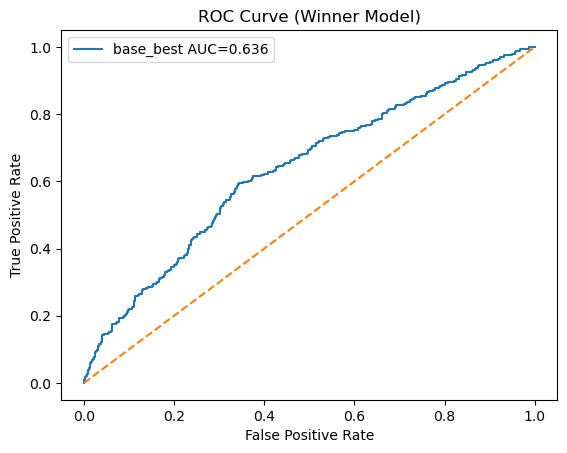

In [47]:
# Compare baseline best vs tuned models and pick a final winner
candidates = {
    "base_best": best_model,
    "logreg_tuned": search_lr.best_estimator_,
    "rf_tuned": search_rf.best_estimator_,
}

winner_name, winner_model, winner_auc = None, None, -1
for name, m in candidates.items():
    y_prob = m.predict_proba(X_test_d)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    if auc > winner_auc:
        winner_name, winner_model, winner_auc = name, m, auc

y_prob = winner_model.predict_proba(X_test_d)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Winner:", winner_name, "AUC:", winner_auc)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"{winner_name} AUC={winner_auc:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Winner Model)")
plt.legend()
plt.show()


Received this warning due to the unbalanced dataset: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Will address further down in the analysis


## 4) Simple feature importance

**What this section does:**
- Extracts the feature names from the `DictVectorizer`.
- If the winning model has `feature_importances_` (tree-based), it uses those values.
- If the model is linear (e.g., Logistic Regression), it uses the **absolute value of coefficients**.
- If neither is available, it falls back to **permutation importance**.
- Ranks features by importance and plots the top features.

**Why we do this:**
Feature importance answers: **“What is the model paying attention to?”**

This is crucial for:
- Explaining model behavior to stakeholders (clinicians, managers, etc.),
- Sanity-checking that important clinical features behave sensibly,
- Detecting weird patterns that might indicate leakage or artifacts.



> Note: this first feature importance view is based on the initial ROC-AUC winner.  
> Later, after training class-weighted models and choosing a new final model, we recompute 
> feature importance again (Section 7.1) so that it matches the **final** model used 
> for fairness slices and deployment.


In [48]:
def top_importances(dv, model, X_test_d, y_test, topk=20, random_state=42):
    """Return a DataFrame of top-k feature importances for tree/linear models,
    with a permutation-importance fallback."""
    feature_names = dv.get_feature_names_out()

    if hasattr(model, "feature_importances_"):
        vals = model.feature_importances_
        df_imp = pd.DataFrame({"feature": feature_names, "importance": vals})
    elif hasattr(model, "coef_"):
        coefs = model.coef_.ravel()
        df_imp = pd.DataFrame({"feature": feature_names, "importance": np.abs(coefs)})
    else:
        perm = permutation_importance(
            model, X_test_d, y_test, n_repeats=5, random_state=random_state, n_jobs=-1
        )
        df_imp = pd.DataFrame({"feature": feature_names, "importance": perm.importances_mean})

    return df_imp.sort_values("importance", ascending=False).head(topk).reset_index(drop=True)

imp_df = top_importances(dv, winner_model, X_test_d, y_test, topk=20)

imp_df


,feature,importance
0,diabetes=0,0.630708
1,hypertension=0,0.630418
2,diagnosis=Sepsis,0.384097
3,sex=Male,0.312524
4,sex=Female,0.236835
5,creatinine,0.206654
6,diagnosis=Pneumonia,0.098428
7,diabetes=1,0.081349
8,hypertension=1,0.081059
9,diagnosis=Heart Failure,0.057852


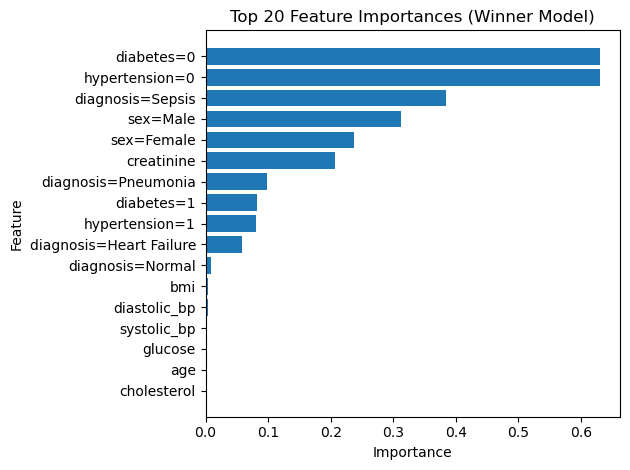

In [49]:

# Plot top feature importances
plt.figure()
plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (Winner Model)")
plt.tight_layout()
plt.show()



## 5) Threshold tuning (handling class imbalance)

The dataset is **imbalanced**: most patients are *not* readmitted.  
With the default threshold (0.5), the model may predict almost everyone as negative,
leading to:
- High accuracy (just reflecting the majority class),
- Very low or zero recall/F1 for the positive (readmitted) class.

Here, we:
- Explore thresholds from 0.10 to 0.90,
- Compute precision, recall, and F1 for each,
- Pick the threshold that **maximizes F1** (you could also optimize recall or a custom cost).


In [50]:

y_prob_winner = winner_model.predict_proba(X_test_d)[:, 1]

thresholds = np.linspace(0.1, 0.9, 17)
rows = []
for t in thresholds:
    y_pred_t = (y_prob_winner >= t).astype(int)
    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec  = recall_score(y_test, y_pred_t, zero_division=0)
    f1   = f1_score(y_test, y_pred_t, zero_division=0)
    rows.append((t, prec, rec, f1))

print("Threshold  Precision  Recall  F1")
for t, prec, rec, f1 in rows:
    print(f"{t:8.2f}  {prec:9.3f}  {rec:6.3f}  {f1:5.3f}")

best_t, best_prec, best_rec, best_f1 = max(rows, key=lambda x: x[3])
print("\nBest F1 threshold for winner model:")
print(f"t = {best_t:.2f}, precision = {best_prec:.3f}, recall = {best_rec:.3f}, f1 = {best_f1:.3f}")

y_pred_best = (y_prob_winner >= best_t).astype(int)
print("\nConfusion matrix at best threshold:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification report at best threshold:")
print(classification_report(y_test, y_pred_best))


Threshold  Precision  Recall  F1
    0.10      0.158   0.844  0.266
    0.15      0.216   0.569  0.313
    0.20      0.269   0.257  0.263
    0.25      0.346   0.098  0.153
    0.30      0.358   0.087  0.140
    0.35      0.500   0.018  0.035
    0.40      0.000   0.000  0.000
    0.45      0.000   0.000  0.000
    0.50      0.000   0.000  0.000
    0.55      0.000   0.000  0.000
    0.60      0.000   0.000  0.000
    0.65      0.000   0.000  0.000
    0.70      0.000   0.000  0.000
    0.75      0.000   0.000  0.000
    0.80      0.000   0.000  0.000
    0.85      0.000   0.000  0.000
    0.90      0.000   0.000  0.000

Best F1 threshold for winner model:
t = 0.15, precision = 0.216, recall = 0.569, f1 = 0.313

Confusion matrix at best threshold:
[[1131  570]
 [ 119  157]]

Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.90      0.66      0.77      1701
           1       0.22      0.57      0.31       276

    accur


## 6) Class-weighted models (LogReg & RandomForest)

Because the dataset is imbalanced, we also try **class-weighted** versions of Logistic Regression and Random Forest:

- `class_weight="balanced"` tells sklearn to give more weight to the minority class.
- This can improves recall and F1 for the positive class, at the cost of some overall accuracy.

We then compare the class-weighted models to see which performs best by ROC AUC.


In [51]:

# Train class-weighted models
models_balanced = {
    "logreg_balanced": LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "rf_balanced": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
}

metrics_balanced = {}
best_bal_name, best_bal_auc, best_bal_model = None, -1, None

for name, m in models_balanced.items():
    m.fit(X_train_d, y_train)
    y_prob = m.predict_proba(X_test_d)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_test, y_prob)
    f1  = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    cm  = confusion_matrix(y_test, y_pred)

    metrics_balanced[name] = {
        "roc_auc": roc,
        "f1": f1,
        "accuracy": acc,
        "conf_matrix": cm
    }

    if roc > best_bal_auc:
        best_bal_name, best_bal_auc, best_bal_model = name, roc, m

print("Balanced-class models performance:")
for name, m in metrics_balanced.items():
    print(f"\n{name}:")
    print(f"  ROC AUC : {m['roc_auc']:.3f}")
    print(f"  F1      : {m['f1']:.3f}")
    print(f"  Accuracy: {m['accuracy']:.3f}")
    print(f"  Confusion matrix:\n{m['conf_matrix']}")

print("\nBest balanced model:", best_bal_name, "AUC:", best_bal_auc)


Balanced-class models performance:

logreg_balanced:
  ROC AUC : 0.636
  F1      : 0.317
  Accuracy: 0.645
  Confusion matrix:
[[1113  588]
 [ 113  163]]

rf_balanced:
  ROC AUC : 0.612
  F1      : 0.007
  Accuracy: 0.860
  Confusion matrix:
[[1700    1]
 [ 275    1]]

Best balanced model: logreg_balanced AUC: 0.6362071756596717



### 6.1 Threshold tuning for the best class-weighted model

We repeat threshold tuning for the **best class-weighted model** to see if we can
further improve recall and F1 on readmissions.


In [52]:

y_prob_bal = best_bal_model.predict_proba(X_test_d)[:, 1]

thresholds_bal = np.linspace(0.1, 0.9, 17)
rows_bal = []
for t in thresholds_bal:
    y_pred_t = (y_prob_bal >= t).astype(int)
    prec = precision_score(y_test, y_pred_t, zero_division=0)
    rec  = recall_score(y_test, y_pred_t, zero_division=0)
    f1   = f1_score(y_test, y_pred_t, zero_division=0)
    rows_bal.append((t, prec, rec, f1))

print("Balanced model – Threshold  Precision  Recall  F1")
for t, prec, rec, f1 in rows_bal:
    print(f"{t:8.2f}  {prec:9.3f}  {rec:6.3f}  {f1:5.3f}")

best_t_bal, best_prec_bal, best_rec_bal, best_f1_bal = max(rows_bal, key=lambda x: x[3])
print("\nBalanced model – Best F1 threshold:")
print(f"t = {best_t_bal:.2f}, precision = {best_prec_bal:.3f}, recall = {best_rec_bal:.3f}, f1 = {best_f1_bal:.3f}")

y_pred_best_bal = (y_prob_bal >= best_t_bal).astype(int)
print("\nBalanced model – Confusion matrix at best threshold:")
print(confusion_matrix(y_test, y_pred_best_bal))

print("\nBalanced model – Classification report at best threshold:")
print(classification_report(y_test, y_pred_best_bal))


Balanced model – Threshold  Precision  Recall  F1
    0.10      0.140   1.000  0.245
    0.15      0.140   1.000  0.245
    0.20      0.140   1.000  0.245
    0.25      0.140   1.000  0.245
    0.30      0.140   1.000  0.246
    0.35      0.143   0.989  0.250
    0.40      0.156   0.862  0.264
    0.45      0.195   0.634  0.298
    0.50      0.217   0.591  0.317
    0.55      0.219   0.540  0.312
    0.60      0.249   0.286  0.266
    0.65      0.345   0.109  0.165
    0.70      0.347   0.094  0.148
    0.75      0.364   0.058  0.100
    0.80      0.000   0.000  0.000
    0.85      0.000   0.000  0.000
    0.90      0.000   0.000  0.000

Balanced model – Best F1 threshold:
t = 0.50, precision = 0.217, recall = 0.591, f1 = 0.317

Balanced model – Confusion matrix at best threshold:
[[1113  588]
 [ 113  163]]

Balanced model – Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1701
           1 


## 7) Fairness slices (Sex, Age bands)

**What this section does:**
- Defines a helper function `eval_slice` that evaluates model performance on a **subset** of the data.
- Creates performance summaries (AUC, F1, Accuracy, sample size) by:
  - `sex` (e.g., male vs female),
  - `age_band` (`<40`, `40–64`, `65+`).

**Why we do this:**
Even if a model looks good overall, it might **underperform for specific groups**.

For example:
- Are predictions less accurate for younger vs older patients?
- Does performance differ by sex?

By checking metrics on these slices, we run a **basic fairness and robustness check**.
In real projects, this is an important step to avoid building models that systematically disadvantage certain groups.

Here, we use the **best class-weighted model** and its **best F1 threshold**.


In [53]:
def eval_slice(df_slice, model, threshold):
    Xs = df_slice[feat_cols].copy()
    for c in ["sex", "diabetes", "hypertension", "diagnosis"]:
        Xs[c] = Xs[c].astype(str)
    Xsd = dv.transform(Xs.to_dict(orient="records"))
    ys = df_slice[target_col].astype(int).values
    y_prob = model.predict_proba(Xsd)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "auc": float(roc_auc_score(ys, y_prob)),
        "f1": float(f1_score(ys, y_pred)),
        "acc": float(accuracy_score(ys, y_pred)),
        "n": int(len(df_slice))
    }

# Fairness by sex
sex_results = {}
for s in df["sex"].astype(str).unique():
    sex_results[s] = eval_slice(df[df["sex"].astype(str) == s], best_bal_model, best_t_bal)

sex_results


{'Male': {'auc': 0.6173170267440754,
  'f1': 0.30123851378345984,
  'acc': 0.633563796354494,
  'n': 4773},
 'Female': {'auc': 0.6343467566694633,
  'f1': 0.3097412480974125,
  'acc': 0.645079240853062,
  'n': 5111}}

In [54]:

# Fairness by age bands
bins = [-1, 39, 64, 200]
labels = ["<40", "40-64", "65+"]
df["age_band"] = pd.cut(df["age"], bins=bins, labels=labels)

age_results = {}
for b in labels:
    age_results[b] = eval_slice(df[df["age_band"] == b], best_bal_model, best_t_bal)

age_results


{'<40': {'auc': 0.6538486312399356,
  'f1': 0.34285714285714286,
  'acc': 0.6572280178837556,
  'n': 2013},
 '40-64': {'auc': 0.6223155338492343,
  'f1': 0.29463941380640185,
  'acc': 0.6362370723945903,
  'n': 5028},
 '65+': {'auc': 0.6109497054680497,
  'f1': 0.29838709677419356,
  'acc': 0.6327822722476257,
  'n': 2843}}

### 7.1 Updated feature importance (best class-weighted model)

So far, we computed feature importance for the earlier "winner" model.  
However, our **final chosen model** for deployment and fairness analysis is the **best class-weighted model** (`best_bal_model`), evaluated at its tuned threshold.

In this section, we recompute feature importance using the **same helper function** (`top_importances`) but applied to `best_bal_model`. This aligns the explanation of "what the model pays attention to" with the model we actually plan to use in practice.

We again:
- Rank features by importance, and
- Visualize the top features in a bar chart.

This helps us confirm that the final model is focusing on clinically sensible variables (e.g., age, diagnosis, vitals) and not on spurious artifacts.

In [55]:
# Updated feature importance for the best class-weighted model

# This reuses the previously defined helper:
# top_importances(dv, model, X_test_d, y_test, topk=20)

imp_bal_df = top_importances(dv, best_bal_model, X_test_d, y_test, topk=20)

print("Top 20 feature importances for the best class-weighted model:")
imp_bal_df

Top 20 feature importances for the best class-weighted model:


,feature,importance
0,diabetes=1,0.392474
1,hypertension=1,0.380833
2,diabetes=0,0.356576
3,hypertension=0,0.344935
4,diagnosis=Sepsis,0.230609
5,creatinine,0.216907
6,diagnosis=Normal,0.140826
7,diagnosis=Heart Failure,0.088570
8,sex=Female,0.053273
9,diagnosis=Pneumonia,0.037111


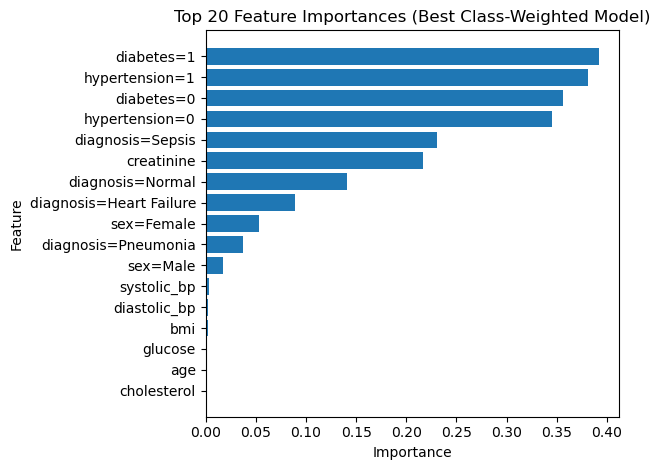

In [56]:
# Plot top feature importances for the class-weighted model
plt.figure()
plt.barh(imp_bal_df["feature"][::-1], imp_bal_df["importance"][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (Best Class-Weighted Model)")
plt.tight_layout()
plt.show()

### 7.2 ROC Curve (Best Class-Weighted Model)

Now that the final model has been selected — the **best class-weighted model** — we recompute the ROC curve using this model's predicted probabilities.

This ensures the ROC visualization reflects the **actual model we deploy**, rather than the earlier baseline/tuned winner.

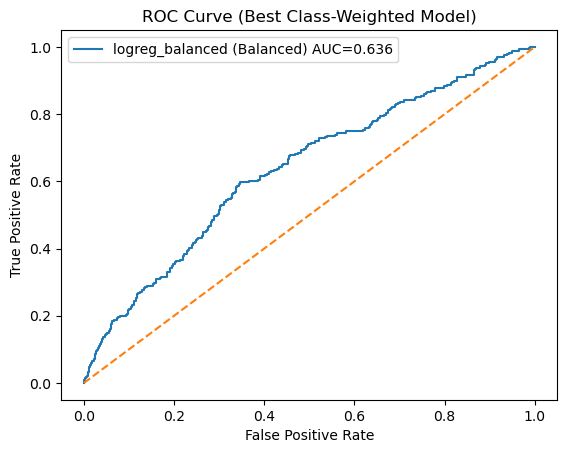

In [57]:
# Get predicted probabilities for the positive class
y_prob_bal = best_bal_model.predict_proba(X_test_d)[:, 1]

# Compute ROC curve points
fpr_bal, tpr_bal, thr_bal = roc_curve(y_test, y_prob_bal)
auc_bal = roc_auc_score(y_test, y_prob_bal)

# Plot ROC curve
plt.figure()
plt.plot(fpr_bal, tpr_bal, label=f"{best_bal_name} (Balanced) AUC={auc_bal:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best Class-Weighted Model)")
plt.legend()
plt.show()

### 7.3 ROC Curve Comparison (Baseline Winner vs Class-Weighted Model)

To understand how the final class-weighted model compares against the original
baseline/tuned winner, we plot **both ROC curves** on the same chart:

- The earlier **winner model** (chosen by ROC AUC before class weighting),
- The **best class-weighted model** (`best_bal_model`).

This helps us see whether the balanced model improves the ranking of positive
cases, even if its raw accuracy or F1 differ.

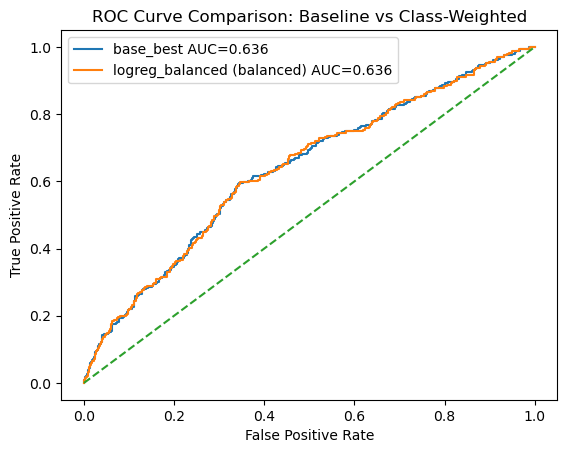

In [58]:
# Probabilities for original winner (if not already stored)
y_prob_winner = winner_model.predict_proba(X_test_d)[:, 1]
auc_winner = roc_auc_score(y_test, y_prob_winner)

# Probabilities for best class-weighted model (already used above)
y_prob_bal = best_bal_model.predict_proba(X_test_d)[:, 1]
auc_bal = roc_auc_score(y_test, y_prob_bal)

# Compute ROC points
fpr_w, tpr_w, _ = roc_curve(y_test, y_prob_winner)
fpr_b, tpr_b, _ = roc_curve(y_test, y_prob_bal)

plt.figure()
plt.plot(fpr_w, tpr_w, label=f"{winner_name} AUC={auc_winner:.3f}")
plt.plot(fpr_b, tpr_b, label=f"{best_bal_name} (balanced) AUC={auc_bal:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Baseline vs Class-Weighted")
plt.legend()
plt.show()

### 7.4 Precision–Recall Curves (Imbalanced Dataset)

Because the dataset is **moderately imbalanced** (most patients are not readmitted),
ROC AUC can sometimes look “okay” even when performance on the positive class is weak.

Precision–Recall (PR) curves focus on:
- **Precision**: out of the patients we predict as high-risk, how many are actually readmitted?
- **Recall**: out of all truly readmitted patients, how many do we correctly flag?

Here we plot PR curves for:
- The original `winner_model`
- The `best_bal_model` with class weights

We also report **Average Precision (AP)**, which is the PR-curve analogue of AUC.

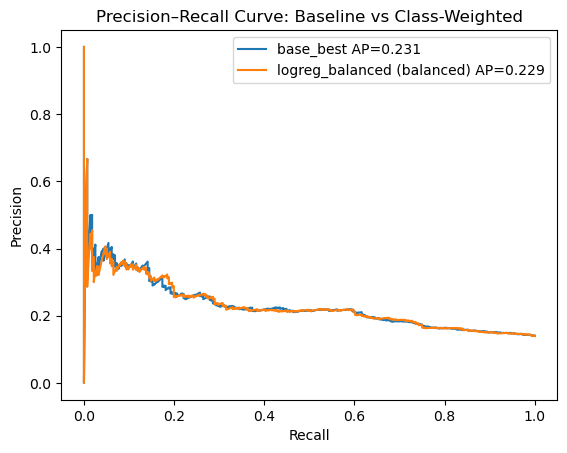

In [59]:
# PR data for original winner model
prec_w, rec_w, _ = precision_recall_curve(y_test, y_prob_winner)
ap_w = average_precision_score(y_test, y_prob_winner)

# PR data for best class-weighted model
prec_b, rec_b, _ = precision_recall_curve(y_test, y_prob_bal)
ap_b = average_precision_score(y_test, y_prob_bal)

plt.figure()
plt.plot(rec_w, prec_w, label=f"{winner_name} AP={ap_w:.3f}")
plt.plot(rec_b, prec_b, label=f"{best_bal_name} (balanced) AP={ap_b:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve: Baseline vs Class-Weighted")
plt.legend()
plt.show()


## 8) Save artifacts (project root `artifacts/`)

**What this section does:**
- Saves the fitted `DictVectorizer` as `dv.joblib`.
- Saves the final best class-weighted model as `model.joblib`.
- Stores them in an `artifacts/` folder in the **project root**, not inside the `notebooks/` folder.
- Writes a small `metrics.json` file with key evaluation details.

**Why we do this:**
This is the bridge between **training** and **deployment**:

- The notebook is where we experiment and iterate.
- The `artifacts/` folder at the project root is what our **scripts (`train.py`, `predict.py`)** and **API (`serve.py`)** will load from.
- Saving both the vectorizer and the model ensures that new data will be transformed **exactly the same way** as during training.
- Saving `metrics.json` gives a quick, reproducible record of which model was exported and how it performed.

In [60]:
# Resolve project root:
# - Current working directory when running the notebook is typically .../readmission_midterm_project/notebooks
# - So parent() is the project root.
PROJECT_ROOT = Path().resolve().parent
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

dv_path = ARTIFACTS_DIR / "dv.joblib"
model_path = ARTIFACTS_DIR / "model.joblib"

# Save vectorizer and best class-weighted model
joblib.dump(dv, dv_path)
joblib.dump(best_bal_model, model_path)

print(f"Saved DictVectorizer to {dv_path}")
print(f"Saved best class-weighted model to {model_path}")

# Build a small metrics / metadata dict to mirror train.py behavior
# (These variables already exist from earlier cells.)
y_prob_bal = best_bal_model.predict_proba(X_test_d)[:, 1]
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

roc = roc_auc_score(y_test, y_prob_bal)
# Using the tuned threshold for the balanced model
y_pred_best_bal = (y_prob_bal >= best_t_bal).astype(int)
f1 = f1_score(y_test, y_pred_best_bal)
acc = accuracy_score(y_test, y_pred_best_bal)

metrics = {
    "model_type": best_bal_name,
    "roc_auc": float(roc),
    "f1_at_best_threshold": float(f1),
    "accuracy_at_best_threshold": float(acc),
    "best_threshold": float(best_t_bal),
    "n_train": int(X_train_d.shape[0]),
    "n_test": int(X_test_d.shape[0]),
    "feature_count": int(len(dv.get_feature_names_out())),
    "features": feat_cols,
    "target": target_col,
}

metrics_path = ARTIFACTS_DIR / "metrics.json"
metrics_path.write_text(json.dumps(metrics, indent=2))
print(f"Saved metrics to {metrics_path}")
metrics


Saved DictVectorizer to /Users/kashundavis/Desktop/ml-zoomcamp-2025/midterm/readmission_midterm_project/artifacts/dv.joblib
Saved best class-weighted model to /Users/kashundavis/Desktop/ml-zoomcamp-2025/midterm/readmission_midterm_project/artifacts/model.joblib
Saved metrics to /Users/kashundavis/Desktop/ml-zoomcamp-2025/midterm/readmission_midterm_project/artifacts/metrics.json


{'model_type': 'logreg_balanced',
 'roc_auc': 0.6362071756596717,
 'f1_at_best_threshold': 0.317429406037001,
 'accuracy_at_best_threshold': 0.6454223571067274,
 'best_threshold': 0.5,
 'n_train': 7907,
 'n_test': 1977,
 'feature_count': 17,
 'features': ['age',
  'sex',
  'bmi',
  'systolic_bp',
  'diastolic_bp',
  'glucose',
  'cholesterol',
  'creatinine',
  'diabetes',
  'hypertension',
  'diagnosis'],
 'target': 'readmission_30d'}

## 9) Serving (FastAPI, aligned with project root `artifacts/`)

We have a separate Python file, `serve.py`, located in the project root that:

- Uses `Path(__file__).parent` to locate the **project root**.
- Loads the artifacts from `artifacts/dv.joblib` and `artifacts/model.joblib`.
- Starts a **FastAPI** web service with a `/predict` endpoint.
- Accepts a JSON payload with patient features, runs the same preprocessing and model prediction, and returns:
  - `readmit_proba` (probability of readmission),
  - `readmit_pred` (0 or 1 based on the selected threshold, currently 0.5 or a tuned value if updated).

Because this notebook now saves artifacts to the **project root `artifacts/` folder**, it is fully aligned with:

- `train.py` (scripted training)
- `predict.py` (batch CSV predictions)
- `serve.py` (FastAPI API)
- `Dockerfile` (containerized service)

You can:

1. Train and export artifacts from the notebook **or** via `train.py`.
2. Run the API locally:

   ```bash
   uvicorn serve:app --reload --port 8000



## 10) Limitations & Next Steps

**Key limitations:**
- The dataset is **synthetic**, so performance here might not match real-world electronic health record (EHR) data.
- The model initially used the **default 0.5 threshold**, which led to almost no positive predictions due to class imbalance.

**Mitigation steps taken in this notebook:**
- Checked class balance and highlighted that accuracy alone is misleading.
- Used **threshold tuning** to find a cutoff that improves F1 and recall for readmissions.
- Trained **class-weighted models** (`class_weight="balanced"`) to give more importance to the minority class.
- Evaluated model performance on **fairness slices** (by `sex` and `age_band`).

**Next steps / future improvements:**
- Try more advanced models (e.g., Gradient Boosting, XGBoost, LightGBM).
- Validate and fine-tune the model on **real clinical data** if and when it becomes available.
